## TPE Tuning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

import optuna

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH_TWO_M")
dataset = pd.read_csv(dataset_path)
dataset.head()

,Gender,Age,DIAGNOSIS,MMSE,Hip ASM,Hip Contrast,Hip Correlation,Hip Variance,Hip Sum Average,Hip Sum Variance,...,ERC CONTRAST,ERC CORRELATION,ERC VARIANCE,ERC SUM AVERAGE,ERC SUM VARIANCE,ERC ENTROPY,ERC CLUSTER SHADE,ERCs_thicknessbaseline,ERCsVolumebaseline,TOTAL_HIPPOCAMPUS_VOLUME
0,0,65.149895,0,30.0,0.460200,83.371297,0.508610,89.066304,10.318461,272.893918,...,245.139997,0.385395,209.332939,41.129640,592.191757,3.234648,18110.527190,6.948,2826.0,6861.9
1,1,67.206024,0,30.0,0.329647,149.712265,0.328176,109.824210,13.761403,289.584573,...,221.932844,0.406722,197.689209,42.149774,568.823992,3.240436,23801.869010,7.090,3792.0,7378.1
2,0,58.773440,0,30.0,0.385797,104.769354,0.545986,125.678783,15.521177,397.945779,...,283.711655,0.336695,217.002950,41.289080,584.300146,3.069283,17579.374770,6.832,2964.0,7983.5
3,0,55.096508,0,30.0,0.229011,166.953431,0.275601,112.186834,18.126786,281.793906,...,231.188679,0.498026,232.827358,33.062621,700.120751,3.093719,4888.606116,6.523,3184.0,8525.1
4,0,48.030117,0,29.0,0.242913,86.816221,0.377439,73.484651,13.463920,207.122381,...,245.120671,0.458936,233.016858,44.574015,686.946759,3.149858,22134.931110,8.253,3419.0,9320.5


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("DIAGNOSIS", axis=1),  
    dataset["DIAGNOSIS"],  
    test_size=0.3,  
    random_state=42,  
)

X_train.shape, X_test.shape

((947, 22), (407, 22))

In [4]:
imputer_knn = IterativeImputer(
    estimator=KNeighborsRegressor(),
    random_state=42,
)

imputer_knn.fit(X_train)
X_train_knn = imputer_knn.transform(X_train)
X_test_knn = imputer_knn.transform(X_test)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [5]:
X_train_knn_t = pd.DataFrame(
    X_train_knn, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_knn_t = pd.DataFrame(
    X_test_knn, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [6]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_knn_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [7]:
X_train_t = pipe.transform(X_train_knn_t)
X_test_t = pipe.transform(X_test_knn_t)

X_train_t.shape, X_test_t.shape

((947, 22), (407, 22))

In [8]:
sel = ['Age', 'MMSE', 'Hip ASM', 'Hip Variance ', 'Hip Sum Average',
       'Hip Sum Variance', 'Hip Entropy', 'ERC CONTRAST', 'ERC SUM VARIANCE',
       'ERC ENTROPY', 'ERCs_thicknessbaseline', 'ERCsVolumebaseline',
       'TOTAL_HIPPOCAMPUS_VOLUME']

In [9]:
# Store selected feature names before transformation
selected_features = [col for col in sel if col in X_train_t.columns]
selected_features

['Age',
 'MMSE',
 'Hip ASM',
 'Hip Variance ',
 'Hip Sum Average',
 'Hip Sum Variance',
 'Hip Entropy',
 'ERC CONTRAST',
 'ERC SUM VARIANCE',
 'ERC ENTROPY',
 'ERCs_thicknessbaseline',
 'ERCsVolumebaseline',
 'TOTAL_HIPPOCAMPUS_VOLUME']

In [10]:
# Transform training and test sets using selected features
X_train_t = X_train_t[selected_features]
X_test_t = X_test_t[selected_features]

X_train_t.shape, X_test_t.shape

((947, 13), (407, 13))

## TPE

In [11]:
def objective(trial):
        
    skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
            
    xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 200, 500)
    xgb_max_depth = trial.suggest_int("xgb_max_depth", 2, 3)
    xgb_learning_rate = trial.suggest_float("xgb_learning_rate", 0.01, 0.2)
    xgb_subsample = trial.suggest_float("xgb_subsample", 0.5, 0.8)
    xgb_colsample_bytree = trial.suggest_float("xgb_colsample_bytree", 0.6, 0.8)
    xgb_min_child_weight = trial.suggest_int("xgb_min_child_weight", 1, 6)
    xgb_gamma = trial.suggest_float("xgb_gamma", 0.0, 2.0)

    model = XGBClassifier(
        n_estimators=xgb_n_estimators,
        max_depth=xgb_max_depth,
        learning_rate=xgb_learning_rate,
        subsample=xgb_subsample,
        colsample_bytree=xgb_colsample_bytree,
        min_child_weight=xgb_min_child_weight,
        gamma=xgb_gamma,
        objective="multi:softprob",
        num_class=len(set(y_train))
    )

    score = cross_val_score(model, X_train_t, y_train, scoring="balanced_accuracy", cv=skf)
    
    accuracy = score.mean()
    
    return accuracy

In [12]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
)

study.optimize(objective, n_trials=20)

[I 2025-05-21 12:13:29,995] A new study created in memory with name: no-name-56e57d2f-fd2c-4196-9d38-aac944c7cda5
[I 2025-05-21 12:13:35,610] Trial 0 finished with value: 0.5347396819726542 and parameters: {'xgb_n_estimators': 234, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.12546452061740604, 'xgb_subsample': 0.5048887296742726, 'xgb_colsample_bytree': 0.7850468635957368, 'xgb_min_child_weight': 1, 'xgb_gamma': 1.6024801258581962}. Best is trial 0 with value: 0.5347396819726542.
[I 2025-05-21 12:13:41,403] Trial 1 finished with value: 0.5286709656872196 and parameters: {'xgb_n_estimators': 358, 'xgb_max_depth': 2, 'xgb_learning_rate': 0.13505516162595602, 'xgb_subsample': 0.7260426235023233, 'xgb_colsample_bytree': 0.7291396251434399, 'xgb_min_child_weight': 1, 'xgb_gamma': 1.826559183460831}. Best is trial 0 with value: 0.5347396819726542.
[I 2025-05-21 12:13:45,678] Trial 2 finished with value: 0.539870367850244 and parameters: {'xgb_n_estimators': 212, 'xgb_max_depth': 3, 'xgb_learn

In [13]:
study.best_params

{'xgb_n_estimators': 382,
 'xgb_max_depth': 3,
 'xgb_learning_rate': 0.1376495389631896,
 'xgb_subsample': 0.5434821730088736,
 'xgb_colsample_bytree': 0.6153687482860702,
 'xgb_min_child_weight': 1,
 'xgb_gamma': 0.9531399531056968}

In [14]:
study.best_value

0.544979341264171

In [15]:
r = study.trials_dataframe()
r.head()

,number,value,datetime_start,datetime_complete,duration,params_xgb_colsample_bytree,params_xgb_gamma,params_xgb_learning_rate,params_xgb_max_depth,params_xgb_min_child_weight,params_xgb_n_estimators,params_xgb_subsample,state
0,0,0.534740,2025-05-21 12:13:29.998211,2025-05-21 12:13:35.610316,0 days 00:00:05.612105,0.785047,1.602480,0.125465,3,1,234,0.504889,COMPLETE
1,1,0.528671,2025-05-21 12:13:35.620986,2025-05-21 12:13:41.402428,0 days 00:00:05.781442,0.729140,1.826559,0.135055,2,1,358,0.726043,COMPLETE
2,2,0.539870,2025-05-21 12:13:41.406425,2025-05-21 12:13:45.676977,0 days 00:00:04.270552,0.708505,1.535945,0.157974,3,1,212,0.655479,COMPLETE
3,3,0.534151,2025-05-21 12:13:45.680894,2025-05-21 12:13:51.745197,0 days 00:00:06.064303,0.766981,1.158746,0.179740,2,5,298,0.617950,COMPLETE
4,4,0.524441,2025-05-21 12:13:51.760449,2025-05-21 12:13:57.561025,0 days 00:00:05.800576,0.788781,1.310438,0.110401,3,4,271,0.669988,COMPLETE


C:\Users\steve\AppData\Local\Temp\ipykernel_11724\2278197192.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


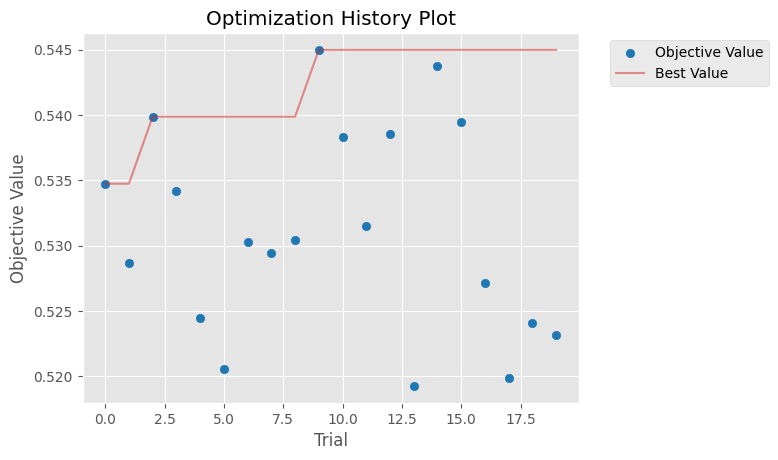

In [16]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_11724\1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

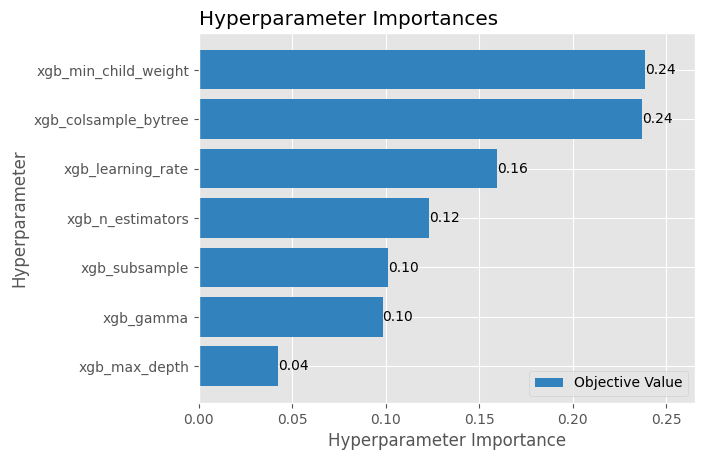

In [17]:
optuna.visualization.matplotlib.plot_param_importances(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_11724\1403512554.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(


array([<Axes: xlabel='xgb_colsample_bytree', ylabel='Objective Value'>,
       <Axes: xlabel='xgb_gamma'>, <Axes: xlabel='xgb_learning_rate'>,
       <Axes: xlabel='xgb_max_depth'>,
       <Axes: xlabel='xgb_min_child_weight'>,
       <Axes: xlabel='xgb_n_estimators'>, <Axes: xlabel='xgb_subsample'>],
      dtype=object)

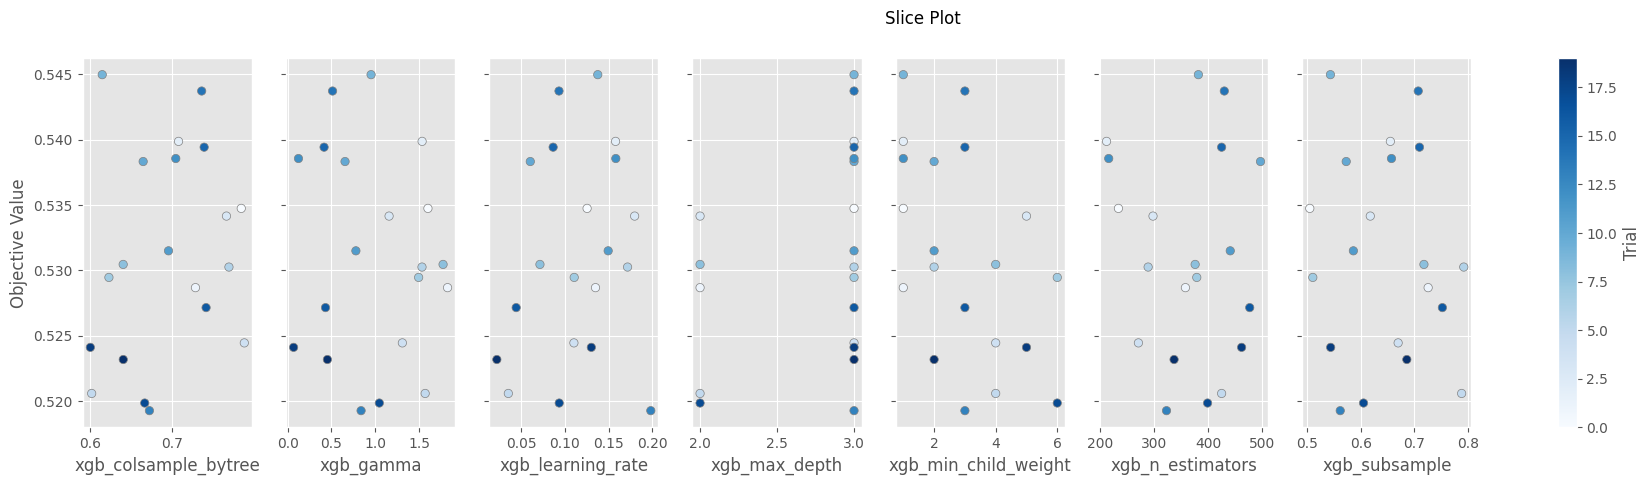

In [18]:
optuna.visualization.matplotlib.plot_slice(
    study,
    params=["xgb_n_estimators", "xgb_max_depth", "xgb_learning_rate", 
            'xgb_subsample', 'xgb_colsample_bytree', 'xgb_min_child_weight',
            'xgb_gamma'],
)

C:\Users\steve\AppData\Local\Temp\ipykernel_11724\2601326980.py:1: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_edf([study])


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

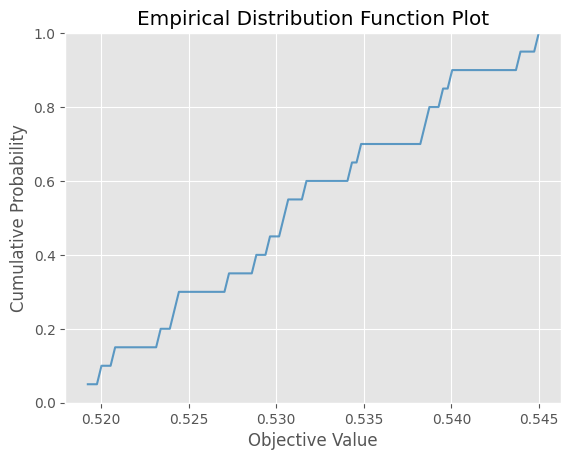

In [19]:
optuna.visualization.matplotlib.plot_edf([study])

## Classification

In [20]:
def run_model(classifier_name, sel_method, X_train, y_train):
        
        model = XGBClassifier(
                n_estimators=study.best_params["xgb_n_estimators"],
                max_depth=study.best_params["xgb_max_depth"],
                learning_rate=study.best_params["xgb_learning_rate"],
                subsample=study.best_params["xgb_subsample"],
                colsample_bytree=study.best_params["xgb_colsample_bytree"],
                min_child_weight=study.best_params["xgb_min_child_weight"],
                gamma=study.best_params["xgb_gamma"],
                objective="multi:softprob",
                num_class=len(set(y_train))
        )

        if sel_method == "Boruta":
                sel_method = "Boruta" 
        else: 
                sel_method = "Complete"
        
        skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=skf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": sel_method,
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": len(X_train.columns),
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [21]:
trained_xgb_n, metrics_xgb_n = run_model("XGBoost", "Complete", X_train_knn_t, y_train)
trained_xgb_t, metrics_xgb_t = run_model("XGBoost", "Boruta", X_train_t, y_train)

In [22]:
validation_df = pd.concat([metrics_xgb_n, metrics_xgb_t])
validation_df_report = validation_df.set_index(["Classifier", "Metric", "Feature Selection", "Fit Time", "Total Features"])
validation_df_report

Mean Train  \
Classifier Metric            Feature Selection Fit Time Total Features               
XGBoost    balanced_accuracy Complete          1.080    22                   0.958   
                             Boruta            0.756    13                   0.934   

                                                                        Std Train  \
Classifier Metric            Feature Selection Fit Time Total Features              
XGBoost    balanced_accuracy Complete          1.080    22                  0.006   
                             Boruta            0.756    13                  0.006   

                                                                        Mean Test  \
Classifier Metric            Feature Selection Fit Time Total Features              
XGBoost    balanced_accuracy Complete          1.080    22                  0.550   
                             Boruta            0.756    13                  0.545   

                                                                        Std Test  
Classifier Metric            Feature Selection Fit Time Total Features            
XGBoost    balanced_accuracy Complete          1.080    22                 0.046  
                             Boruta            0.756    13                 0.053

In [23]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": round(accuracy_score(y_train, pred_train), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_train, pred_train), 3),
                "precision": round(precision_score(y_train, pred_train, average="weighted", zero_division=0), 3),
                "recall": round(recall_score(y_train, pred_train, average="weighted", zero_division=0), 3),
                "f1_weighted": round(f1_score(y_train, pred_train, average="weighted", zero_division=0), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_train, pred_train_proba, average="weighted", multi_class="ovr"),3,),
        }
        
        metrics_test = {
                "accuracy": round(accuracy_score(y_test, pred_test), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_test, pred_test), 3),
                "precision": round(precision_score(y_test, pred_test, average="weighted", zero_division=0), 3),
                "recall": round(recall_score(y_test, pred_test, average="weighted", zero_division=0), 3),
                "f1_weighted": round(f1_score(y_test, pred_test, average="weighted", zero_division=0), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_test, pred_test_proba, average="weighted", multi_class="ovr"),3,),
        }
                
        elapsed_time = time.time() - start_time
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "Boruta",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": len(X_train.columns),
                "Metric": metrics_train.keys(),
                "Train data": metrics_train.values(),
                "Test data": metrics_test.values(),
    })
        
        return pred_metrics_df

In [24]:
results = "all"
prediction_df_report = None

if results == "all":
    
    pred_xgb_n = eval_model("XGBoost", trained_xgb_n, X_train_knn_t, X_test_knn_t, y_train, y_test)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_xgb_n, pred_xgb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":

    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_xgb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier Classification Time Total Features Metric                             
Boruta            XGBoost    0.40                22             accuracy                   0.975   
                                                                balanced_accuracy          0.953   
                                                                precision                  0.975   
                                                                recall                     0.975   
                                                                f1_weighted                0.974   
                                                                roc_auc_ovr_weighted       0.999   
                             0.14                13             accuracy                   0.954   
                                                                balanced_accuracy          0.926   
                                                                precision                  0.954   
                                                                recall                     0.954   
                                                                f1_weighted                0.953   
                                                                roc_auc_ovr_weighted       0.996   

                                                                                      Test data  
Feature Selection Classifier Classification Time Total Features Metric                           
Boruta            XGBoost    0.40                22             accuracy                  0.732  
                                                                balanced_accuracy         0.568  
                                                                precision                 0.714  
                                                                recall                    0.732  
                                                                f1_weighted               0.715  
                                                                roc_auc_ovr_weighted      0.893  
                             0.14                13             accuracy                  0.720  
                                                                balanced_accuracy         0.554  
                                                                precision                 0.700  
                                                                recall                    0.720  
                                                                f1_weighted               0.702  
                                                                roc_auc_ovr_weighted      0.885

### Export model

In [25]:
import pickle

# Save the trained model using pickle
with open("xgboost_model.pkl", "wb") as file:
    pickle.dump(trained_xgb_t, file)

print("XGBppst model saved successfully!")

XGBppst model saved successfully!
